# Visualization and Analytics

- **Basic visualizations:**
  - Open HEALPix/Zarr data from Cloud
  - Selecting areas/cells
  - Interactive plotting DGGS grids over a map
- **Simple analytics:**
  - Example: time series over selected cells. 


In [1]:
import intake
import numpy as np
import xdggs  

##   Open HEALPix/Zarr data from Cloud

We make use of data shared during the World Climate Research Programme Global KM-scale Hackathon.  These data has the same grid format as Destination Earth Climate Digital Twin data, in HEALPix, but published in Zarr format. 

In [2]:
cat = intake.open_catalog(
    "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
)["online"]
refinement_level = 9
ds = (
    cat.icon_ngc4008(zoom=refinement_level, 
                     chunks={"cell": 12 * 4**(7), 
                             "time":"10M"})
    .to_dask()
    .squeeze()[['ts']]
)
ds

/Users/todaka/micromamba/envs/xdggs_demo/lib/python3.13/site-packages/intake_xarray/xzarr.py:46: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  self._ds = xr.open_dataset(self.urlpath, **kw)
/Users/todaka/micromamba/envs/xdggs_demo/lib/python3.13/site-packages/intake_xarray/xzarr.py:46: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  self._ds = xr.open_dataset(self.urlpath, **kw)
/Users/todaka/micromamba/envs/xdggs_demo/lib/python3.13/site-packages/intake_xarray/xzarr.py:46: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  self._ds = xr.open_dataset(self.urlpath, **kw)
/Users/todaka/micr

<xarray.Dataset> Size: 138GB
Dimensions:  (time: 10958, cell: 3145728)
Coordinates:
    crs      float32 4B nan
  * time     (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
Dimensions without coordinates: cell
Data variables:
    ts       (time, cell) float32 138GB dask.array<chunksize=(12, 196608), meta=np.ndarray>

In [3]:

decoded = ds.assign_coords(
    {
        "cell_ids": (
            "cell",
            np.arange(
                12 * 4**refinement_level,             ),
        )
    }
).dggs.decode(
    {"grid_name": "healpix", "level": refinement_level, "indexing_scheme": "nested"},
)
decoded

<xarray.Dataset> Size: 138GB
Dimensions:   (time: 10958, cell: 3145728)
Coordinates:
    crs       float32 4B nan
  * time      (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
  * cell_ids  (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Dimensions without coordinates: cell
Data variables:
    ts        (time, cell) float32 138GB dask.array<chunksize=(12, 196608), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=9, indexing_scheme=nested)

Using DGGS extention for Xarray, 'xdggs' we let xarray to know what kind of grid system we use and what is the refinement_level we are using.  

##   Selecting areas/cells

Lets chose the area of interest.  

In [4]:
import cdshealpix
from astropy.coordinates import Latitude, Longitude
box = [-5, 40, 5, 55]
polygon = np.array(
    [
        [box[0], box[1]],
        [box[2], box[1]],
        [box[2], box[3]],
        [box[0], box[3]],
    ]
)

lon = Longitude(polygon[:, 0], unit="degree")
lat = Latitude(polygon[:, 1], unit="degree")

cell_ids, _, _ = cdshealpix.nested.polygon_search(
    lon, lat, depth=decoded.dggs.grid_info.level, flat=True
)
subset = decoded.isel(cell=cell_ids)
subset

<xarray.Dataset> Size: 348MB
Dimensions:   (time: 10958, cell: 7939)
Coordinates:
    crs       float32 4B nan
  * time      (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
  * cell_ids  (cell) int64 64kB 172791 172796 172797 ... 1310717 1310718 1310719
Dimensions without coordinates: cell
Data variables:
    ts        (time, cell) float32 348MB dask.array<chunksize=(12, 7939), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=9, indexing_scheme=nested)

## Interactive plotting DGGS grids over a map

Lets plot the zone of interest interactively! 
we have some time step.  We can use cursour to chose which time step to show

In [5]:
subset.isel(time=slice(0,3)).dggs.decode().ts.compute().dggs.explore()

### Xdggs knows the cell centers. 

In [6]:
subset.dggs.cell_centers()

<xarray.Dataset> Size: 127kB
Dimensions:    (cell: 7939)
Coordinates:
    latitude   (cell) float64 64kB 39.94 39.94 40.03 40.03 ... 41.61 41.61 41.71
    longitude  (cell) float64 64kB 4.395 4.219 4.307 4.131 ... 0.08789 359.9 0.0
Dimensions without coordinates: cell
Data variables:
    *empty*

In [7]:
subset.assign_coords(
    subset.dggs.cell_centers().coords
)

<xarray.Dataset> Size: 348MB
Dimensions:    (time: 10958, cell: 7939)
Coordinates:
    crs        float32 4B nan
  * time       (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
  * cell_ids   (cell) int64 64kB 172791 172796 172797 ... 1310718 1310719
    latitude   (cell) float64 64kB 39.94 39.94 40.03 40.03 ... 41.61 41.61 41.71
    longitude  (cell) float64 64kB 4.395 4.219 4.307 4.131 ... 0.08789 359.9 0.0
Dimensions without coordinates: cell
Data variables:
    ts         (time, cell) float32 348MB dask.array<chunksize=(12, 7939), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(level=9, indexing_scheme=nested)

we can derive the cell boundary polygons as an array of Shapely using;

In [8]:
subset.dggs.cell_boundaries()

<xarray.DataArray (cell: 7939)> Size: 64kB
array([<POLYGON ((4.395 39.838, 4.482 39.936, 4.395 40.033, 4.307 39.936, 4.395 39....>,
       <POLYGON ((4.219 39.838, 4.307 39.936, 4.219 40.033, 4.131 39.936, 4.219 39....>,
       <POLYGON ((4.307 39.936, 4.395 40.033, 4.307 40.131, 4.219 40.033, 4.307 39....>,
       ...,
       <POLYGON ((0.088 41.511, 0.176 41.61, 0.088 41.71, 0 41.61, 0.088 41.511))>,
       <POLYGON ((-0.088 41.511, 0 41.61, -0.088 41.71, -0.176 41.61, -0.088 41.511))>,
       <POLYGON ((0 41.61, 0.088 41.71, 0 41.81, -0.088 41.71, 0 41.61))>],
      shape=(7939,), dtype=object)
Coordinates:
    cell_ids  (cell) int64 64kB 172791 172796 172797 ... 1310717 1310718 1310719
Dimensions without coordinates: cell

## Example: time series over selected cells. 

xdggs is not an 'add on' or wrapper of xarray. Thus it is designed to be able to use natively all the functionality of Xarray.  (Which is the difference between tools such as uxarray, it is a wrapper. ) 

We can select specific location expressed in latitude and longitude, and apply basic xarray functions. 



In [9]:
latitude = 41 
longitude = 1 

point=subset.dggs.sel_latlon(longitude=longitude, latitude=latitude).ts.isel(time=slice(0,30)).compute()

point=point.assign_coords(
    point.dggs.cell_centers().coords
)

point.dggs.explore(
    center=0, cmap="viridis", alpha=0.8
)

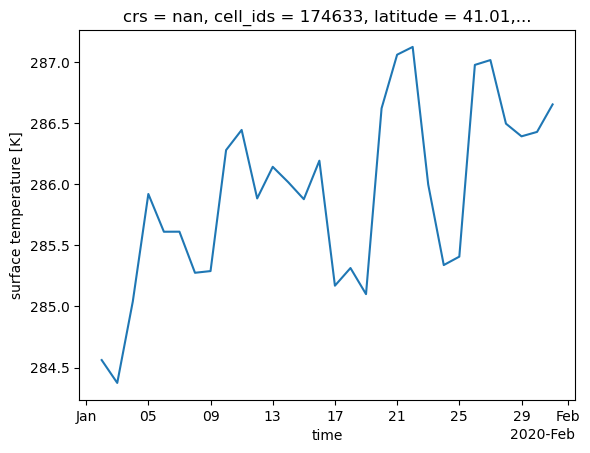

In [10]:
point.plot()
